<a href="https://colab.research.google.com/github/Ronnypetson/titanic/blob/master/soft_hadamard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.optim import Adam

import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
import time
from IPython import display
from IPython.core.debugger import Pdb

def breakpoint():
    Pdb().set_trace()

device = "cuda:0" if torch.cuda.is_available() else "cpu"

%matplotlib inline

### Demonstração PyTorch

In [ ]:
# y = w0 * x² + w1 * x
# (y real: y = 2 * x² + 5 * x)
#
# y = f0(f1(f2(x)))

In [ ]:
a = 2.0 * torch.ones((2, 2)).float()
a.requires_grad = True
b = 3.0 * torch.ones((2, 2)).float()
b.requires_grad = True

In [ ]:
c = (a * b).sum()
c

In [ ]:
c.backward()

In [ ]:
a.grad

In [ ]:
b.grad

In [ ]:
a.grad = None

In [ ]:
b.grad = None

In [ ]:
d = (a * a + b).mean()

In [ ]:
d

In [ ]:
d.backward()

In [ ]:
a.grad

In [ ]:
b.grad

In [ ]:
def y(x, a, b):
  return (a * x * x + b * x).sum(dim=1)

def y_real(x):
  x = torch.tensor(x).float()
  return (2 * x * x + 5 * x).sum(dim=1)

# (y real: y = 2 * x * x + 5 * x)

In [ ]:
from numpy.random import shuffle

X = list(range(1000))
shuffle(X)
X = torch.tensor(X).reshape(-1, 1).float()
Y = y_real(X)

In [ ]:
X.shape, Y.shape

In [ ]:
a = torch.tensor(0.5).float()
b = torch.tensor(0.5).float()

a = torch.nn.Parameter(a)
b = torch.nn.Parameter(b)

optim = torch.optim.Adam([a, b], lr=1e-3)

for iter in range(10000):
  Y_pred = y(X, a, b)
  custo = ((Y - Y_pred).abs()).mean()
  optim.zero_grad()
  custo.backward()
  optim.step()
  if iter % 10 == 0:
    print(custo.item())

In [ ]:
a, b

### Soft Hadamard

In [ ]:
tr = ToTensor()

def _transform(x):
  return tr(x) * 2.0 - 1.0

bsize = 64

MNIST_train_data = MNIST(
    'MNIST_root/',
    download=True,
    train=True,
    transform=_transform,
)
train_data_loader = torch.utils.data.DataLoader(
    MNIST_train_data,
    batch_size=bsize,
    shuffle=True,
    num_workers=1,
)

MNIST_test_data = MNIST(
    'MNIST_root_test/',
    download=True,
    train=False,
    transform=_transform,
)
test_data_loader = torch.utils.data.DataLoader(
    MNIST_test_data,
    batch_size=bsize,
    shuffle=True,
    num_workers=1,
)

In [ ]:
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

class HadamardSelfAttention(nn.Module):
  def __init__(self, in_features=28, out_features=32):
    super().__init__()
    self.Wk = nn.Sequential(
        nn.Linear(in_features, out_features, bias=True),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(out_features, out_features, bias=True),
    )
    self.Wq = nn.Sequential(
        nn.Linear(in_features, out_features, bias=True),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(out_features, out_features, bias=True),
    )
    # self.Wv = nn.Linear(in_features, out_features, bias=True)

  def forward(self, x):
    # x: (N, T, D_in)
    n, t, d_in = x.shape
    x = x.reshape(-1, d_in)
    K = self.Wk(x).reshape(n, t, -1)
    Q = self.Wq(x).reshape(n, t, -1)
    # V = self.Wv(x).reshape(n, t, -1)
    V = x.clone().reshape(n, t, -1)
    _, _, d_out = K.shape
    KQ = (
        K.repeat(1, t, 1).reshape(n, t, t, d_out)
        * Q.repeat(1, 1, t).reshape(n, t, t, d_out)
      )
    A = nn.functional.gumbel_softmax(KQ, hard=True, dim=2)
    V = A * V.unsqueeze(1).repeat(1, t, 1, 1)
    V = V.sum(dim=2)
    return V

class MLP(nn.Module):
  def __init__(self, in_features=28, out_features=32, num_classes=10):
    super().__init__()
    pe = getPositionEncoding(in_features, in_features)
    self.pe = torch.tensor(pe).float().to(device)
    self.W = nn.Sequential(
        nn.Linear(in_features, 2 * out_features, bias=True),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(2 * out_features, 2 * out_features, bias=True),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(2 * out_features, num_classes, bias=True),
    )

  def forward(self, x):
    # x: N, 1, T, d_in
    x = x.squeeze(1)
    x = x + self.pe
    n, t, d_in = x.shape
    x = x.reshape(-1, d_in)
    x = self.W(x)
    x = x.reshape(n, t, -1)
    x = x.mean(dim=1)
    return x

class Composer(nn.Module):
  def __init__(self, in_features=28, out_features=32, num_classes=10):
    super().__init__()
    pe = getPositionEncoding(in_features, in_features)
    self.pe = torch.tensor(pe).float().to(device)
    self.hsa = nn.Sequential(
        # nn.Identity(),
        HadamardSelfAttention(in_features, out_features),
        # HadamardSelfAttention(out_features, out_features),
        # HadamardSelfAttention(out_features, out_features),
        # HadamardSelfAttention(out_features, out_features),
    )
    self.clf = nn.Linear(out_features, num_classes)

  def forward(self, x):
    # x: N, 1, T, d_in
    x = x.squeeze(1)
    x = x + self.pe
    x = self.hsa(x)
    self._hsa_out = x
    # x: N, T, d_out
    x = x.mean(dim=1)
    y = self.clf(x)
    return y

In [ ]:
model = Composer(in_features=28, out_features=28, num_classes=10).to(device)
# model = MLP(in_features=28, out_features=28, num_classes=10).to(device)
optimizer = Adam(
    params=model.parameters(),
    lr=1e-3,
)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 100
valid_epoch = []
valid_losses = []
valid_accs = []
for epoch in range(num_epochs):
  model.train()
  for x, y in iter(train_data_loader):
    x = x.to(device)
    y = y.to(device)
    y_pred = model.forward(x)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  model.eval()
  for x, y in iter(test_data_loader):
    x = x.to(device)
    y = y.to(device)
    y_pred = model.forward(x)
    loss = loss_fn(y_pred, y)
    y = y.reshape(-1).tolist()
    y_pred = torch.argmax(y_pred, dim=-1).reshape(-1).tolist()
    valid_epoch.append(epoch)
    valid_losses.append(loss.item())
    valid_accs.append(accuracy_score(y, y_pred))
  loss_df = pd.DataFrame(
      {
          "Epoch": valid_epoch,
          "Loss": valid_losses,
          "Acc": valid_accs,
      }
  )
  display.clear_output(wait=True)
  loss_df.groupby("Epoch").mean().reset_index()[["Loss"]].plot(figsize=(24, 2))
  plt.show()
  loss_df.groupby("Epoch").mean().reset_index()[["Acc"]].plot(figsize=(24, 2))
  plt.show()

In [ ]:
idx = np.random.randint(0, 63)
model.eval()
for x, _ in iter(test_data_loader):
    x = x.to(device)
    break
model.forward(x[idx: idx + 1])
x_ = model._hsa_out.cpu().detach().numpy()
x = x[idx, 0].cpu().detach().numpy()
plt.imshow(x)
plt.show()
plt.imshow(x_[0])
plt.show()

### Implement example of "Produto Interno Maromba": fitting linear transform using maromba product

#### ---

In [ ]:
# # TODO: encapsulate in a class and override @ and +
# # TODO: implement vectorized version and indices
# def maromba_dot(u, v, index_u, index_v):
#   """
#   u: dim_u x 1
#   v: dim_v x 1
#   index_u: dim_u x index_dim
#   index_v: dim_v x index_dim
#   """
#   comb = (u @ v.T).reshape(-1, 1)
#   sim = (index_u @ index_v.T).reshape(1, -1)
#   dot = (sim @ comb)[0, 0]
#   return dot

#### ----

In [14]:
def dotlike(
    a: torch.Tensor,
    b: torch.Tensor,
    op=lambda x, y: x * y,
  ) -> torch.Tensor:
  """
  a: ... x d
  b: d x ...
  """
  d = a.shape[-1]
  N = a.shape[:-1]
  M = b.shape[1:]
  assert d == b.shape[0]
  a = a.reshape(-1, d)
  # b: ... x d
  b = b.reshape(d, -1).T
  N_ = a.shape[0]
  M_ = b.shape[0]
  a = a.unsqueeze(1).repeat(1, M_, 1)
  b = b.unsqueeze(0).repeat(N_, 1, 1)
  dot = op(a, b).sum(dim=-1)
  dot = dot.reshape(N + M)
  return dot

def y(x, W):
  """
  x: N x d_in
  W: d_out x d_in
  """
  return x @ W.T

def combine_indices(index_w, index_x, indexer):
  """
  index_w: d_out x d_in x d_index
  index_x: N x d_in x d_index
  index_new[i, j] = f(index_w.sum(dim=1)[i] + index_x.sum(dim=1)[j]; theta)
  """
  d_out, d_in, d_index = index_w.shape
  n, d_in_, d_index_ = index_x.shape
  assert d_in == d_in_
  assert d_index == d_index_
  idxw_sum = index_w.sum(dim=1)
  # idxw_sum: d_out x N x d_index
  idxw_sum = idxw_sum.unsqueeze(1).repeat(1, n, 1)
  idxx_sum = index_x.sum(dim=1)
  # idxx_sum: d_out x N x d_index
  idxx_sum = idxx_sum.unsqueeze(0).repeat(d_out, 1, 1)
  index_new = indexer(idxw_sum + idxx_sum)
  # index_new: N x d_out x d_index
  index_new = index_new.permute(1, 0, 2)
  index_new = nn.functional.gumbel_softmax(index_new, hard=False, dim=-1)
  # index_new = nn.functional.softmax(index_new, dim=-1)
  return index_new

def batch_maromba_dot(W, x, index_w, index_x, indexer):
  """
  W: d_out x d_in
  x: N x d_in
  index_w: d_out x d_in x d_index
  index_x: N x d_in x d_index
  """
  d_out, d_in = W.shape
  n, d_in_ = x.shape
  d_index = index_w.shape[-1]
  assert d_in == d_in_, "W.shape[1] and x.shape[1] must be equal."
  assert index_w.shape[1:] == index_x.shape[1:]
  # comb: N x d_out x d_in x d_in
  W = W.reshape(-1, 1)
  x = x.T.reshape(1, -1)
  comb = (W @ x).reshape(d_out, d_in, d_in, n)
  comb = comb.permute(3, 0, 1, 2)
  # comb: (N * d_out) x (d_in(W) * d_in(x)) x 1
  comb = comb.reshape(n * d_out, d_in * d_in, 1)
  index_x = index_x.permute(2, 1, 0)
  # index_x: d_index x (d_in * N)
  index_x = index_x.reshape(d_index, d_in * n)
  # index_w: (d_out * d_in) x d_index
  index_w = index_w.reshape(d_out * d_in, d_index)
  sim = (index_w @ index_x).reshape(d_out, d_in, d_in, n)
  sim = sim.permute(3, 0, 1, 2)
  sim = sim.reshape(n * d_out, 1, d_in * d_in)
  # Overview of shapes:
  # sim:  (N * d_out) x 1 x (d_in(W) * d_in(x))
  # comb: (N * d_out) x (d_in(W) * d_in(x)) x 1
  # Matrix product of the last two dimensions seems correct.
  dot = torch.bmm(sim, comb)[:, 0, 0]
  dot = dot.reshape(n, d_out)
  index_w = index_w.reshape(d_out, d_in, d_index)
  index_x = index_x.reshape(d_index, d_in, n).permute(2, 1, 0)
  index_new = combine_indices(index_w, index_x, indexer)
  return dot, index_new

def batch_maromba_dot_(u, v, index_u, index_v):
  """
  u: N x dim_u
  v: N x dim_v
  index_u: N x dim_u x index_dim
  index_v: N x dim_v x index_dim
  """
  n, dim_u = u.shape
  m, dim_v = v.shape
  assert n == m, "u.shape[0] and v.shape[0] must be equal."
  u = u.reshape(n, dim_u, 1)
  v = v.reshape(n, 1, dim_v)
  # comb: N x dim_u x dim_v
  comb = torch.bmm(u, v)
  comb = comb.reshape(n, -1, 1)
  index_v = index_v.permute(0, 2, 1)
  # sim: N x dim_u x dim_v
  sim = torch.bmm(index_u, index_v)
  sim = sim.reshape(n, 1, -1)
  # dot: N
  dot = torch.bmm(sim, comb)[:, 0, 0]
  return dot

def maromba_loss(y_true, y_pred, true_index, pred_index, debug=False):
  """
  y_true: N x d_out
  y_pred: N x d_out
  true_index: N x d_out x d_index
  pred_index: N x d_out x d_index
  """
  assert y_true.shape == y_pred.shape
  assert true_index.shape == pred_index.shape
  dot_true = torch.bmm(y_true.unsqueeze(1), y_true.unsqueeze(-1))[:, 0, 0]
  dot_pred = torch.bmm(y_pred.unsqueeze(1), y_pred.unsqueeze(-1))[:, 0, 0]
  mdot_true_pred = batch_maromba_dot_(y_true, y_pred, true_index, pred_index)
  index_match = (pred_index.mean(dim=0) @ true_index.mean(dim=0).T)
  dot_loss = ((dot_true - mdot_true_pred).abs()).mean()
  mu_loss = (y_true.mean(dim=-1) - y_pred.mean(dim=-1)).abs().mean()
  index_loss_0 = (1.0 - index_match.sum(dim=0)).abs().mean()
  index_loss_1 = (1.0 - index_match.sum(dim=-1)).abs().mean()
  if debug:
    Pdb().set_trace() ###
  loss = (dot_loss + mu_loss + index_loss_0 + index_loss_1)
  return loss

In [11]:
in_dim = 5
out_dim = 10
index_dim = in_dim + out_dim # making things easier
__hidden_dim = 5 * index_dim
num_examples = 20000

# Ground-truth parameters
W_true = torch.randn((out_dim, in_dim), requires_grad=False)
W_true = W_true.float().to(device)

# Parameters to be trained
bag_values_W = nn.Parameter(torch.randn((out_dim, in_dim)))
bag_values_W = bag_values_W.float().to(device)
bag_indices_W = nn.Parameter(torch.randn((out_dim, in_dim, index_dim)))
bag_indices_W = bag_indices_W.float().to(device)

# Indexer model to be trained
indexer = nn.Sequential(
    nn.Linear(index_dim, __hidden_dim),
    # nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(__hidden_dim, index_dim),
).to(device)

# Input data
values_x = 1e0 * torch.randn((num_examples, in_dim))
# index_x = torch.randn((1, in_dim, index_dim)).repeat(num_examples, 1, 1)
index_x = torch.eye(index_dim)[:in_dim]
index_x = index_x.unsqueeze(0).repeat(num_examples, 1, 1)

# Ground-truth target
y_true = y(values_x, W_true)
# y_true_index = torch.randn((1, out_dim, index_dim)).repeat(num_examples, 1, 1)
y_true_index = torch.eye(index_dim)[in_dim:]
# y_true_index = nn.functional.gumbel_softmax(
#     y_true_index[torch.randperm(out_dim)]
#     + y_true_index[torch.randperm(out_dim)],
#     dim=1,
#     hard=False,
# )
y_true_index = y_true_index.unsqueeze(0).repeat(num_examples, 1, 1)

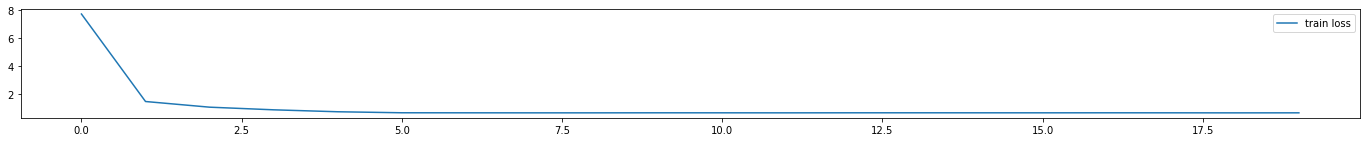

In [12]:
opt_vectors = Adam([bag_values_W, bag_indices_W], lr=1e-3)
opt_indexer = Adam(indexer.parameters(), lr=1e-3)

num_epochs = 20
batch_size = 32
epoch_len = num_examples // batch_size

all_losses = []
for epoch in range(num_epochs):
  epoch_losses = []
  for _ in range(epoch_len):
    batch_idx = np.random.choice(num_examples, batch_size)
    batch_x = values_x[batch_idx].float().to(device)
    batch_x_index = index_x[batch_idx].float().to(device)
    batch_y_true = y_true[batch_idx].float().to(device)
    batch_y_true_index = y_true_index[batch_idx].float().to(device)
    y_pred_val, y_pred_index = batch_maromba_dot(
        bag_values_W, batch_x, bag_indices_W, batch_x_index, indexer
    )
    loss = maromba_loss(batch_y_true, y_pred_val, batch_y_true_index, y_pred_index)
    opt_vectors.zero_grad()
    opt_indexer.zero_grad()
    loss.backward()
    opt_vectors.step()
    opt_indexer.step()
    epoch_losses.append(loss.item())
  all_losses.append(np.mean(epoch_losses))
  df_train = pd.DataFrame({
      "train loss": all_losses,
  })
  display.clear_output(wait=True)
  df_train.plot(figsize=(24, 2))
  plt.show()

In [13]:
print(np.mean(all_losses[-5:]))
# y_pred_index.shape, batch_y_true_index.shape
index_match = (y_pred_index[0] @ batch_y_true_index[0].T)
print(index_match.sum(dim=-1))
print(index_match.sum(dim=0))

0.633822693901062
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<SumBackward1>)
tensor([1.0000e+00, 1.0000e+00, 5.0872e-09, 6.8137e-08, 1.0000e+00, 3.0000e+00,
        1.0000e+00, 4.4796e-08, 2.0000e+00, 1.0000e+00],
       grad_fn=<SumBackward1>)


In [ ]:
maromba_loss(
    batch_y_true, y_pred_val, batch_y_true_index, y_pred_index, debug=True
)

In [ ]:
W_true

In [ ]:
bag_values_W

In [ ]:
bag_indices_W